In [2]:
library(tidyverse)
library(caret)
library(Biobase)
library(PharmacoGx)
library(Hmisc)
library(glmnet)
library(mRMRe)
library(SummarizedExperiment)
library(ggplot2)

In [3]:
options(stringsAsFactors = F)

### Read in PSets

In [4]:
gCSI <- readRDS("gCSI.rds")

### Extract transcript expression matrix from PSets

In [5]:
#genes as rows, cell lines as columns
expr <- as.data.frame(assay(summarizeMolecularProfiles(gCSI, mDataType = "Kallisto_0.46.1.isoforms", 
                                                       fill.missing = FALSE)))

Summarizing Kallisto_0.46.1.isoforms molecular data for:	gCSI



  |======================================================================| 100%


### Extract feature data from Ensembl (%GC content, gene length, and miRNA binding)

In [7]:
expr_features <- gCSI@molecularProfiles$Kallisto_0.46.1.isoforms@elementMetadata #feature metadata from PSet
expr_features$gene_id_stable <- gsub("\\..*","",expr_features$gene_id) #remove "." versions at end of gene_id for miRNA matching
ensembl_features <- read.csv("ensembl_hg38_features.txt") #%GC content, transcript length
ensembl_features_miRNA <- read.csv("ensembl_hg38_features_miRNA.txt", sep = "\t") #miRNA bindings to gene

### Assign Ensembl feature data to expression matrix

In [19]:
#expr$type <- expr_features$transcript_type # transcript type (e.g. lncRNA)
#expr <- transform(expr,type_id=as.numeric(factor(type))) #assign numerial to each unique type (for training model)

expr$GC <- ensembl_features$Gene...GC.content[match(expr_features$transcript_id, ensembl_features$Transcript.stable.ID.version)] # %GC content
ensembl_features$gene_length <- (ensembl_features$Gene.end..bp.-ensembl_features$Gene.start..bp.) + 1
expr$length <- ensembl_features$gene_length[match(expr_features$gene_id, ensembl_features$Gene.stable.ID.version)] # gene length

#expr$mirna <- ensembl_features_miRNA$miRNA.identifier[match(expr_features$gene_id_stable, ensembl_features_miRNA$Ensembl.gene.ID)] #miRNA

### Assign MEAN of feature for any NAs

In [20]:
#%GC content
mean_gc <- mean(expr$GC[which(!is.na(expr$GC))])
expr$GC[which(is.na(expr$GC))] <- mean_gc

#%Gene length
mean_length <- mean(expr$length[which(!is.na(expr$length))])
expr$length[which(is.na(expr$length))] <- mean_length

### Plot feature distribution (expression)

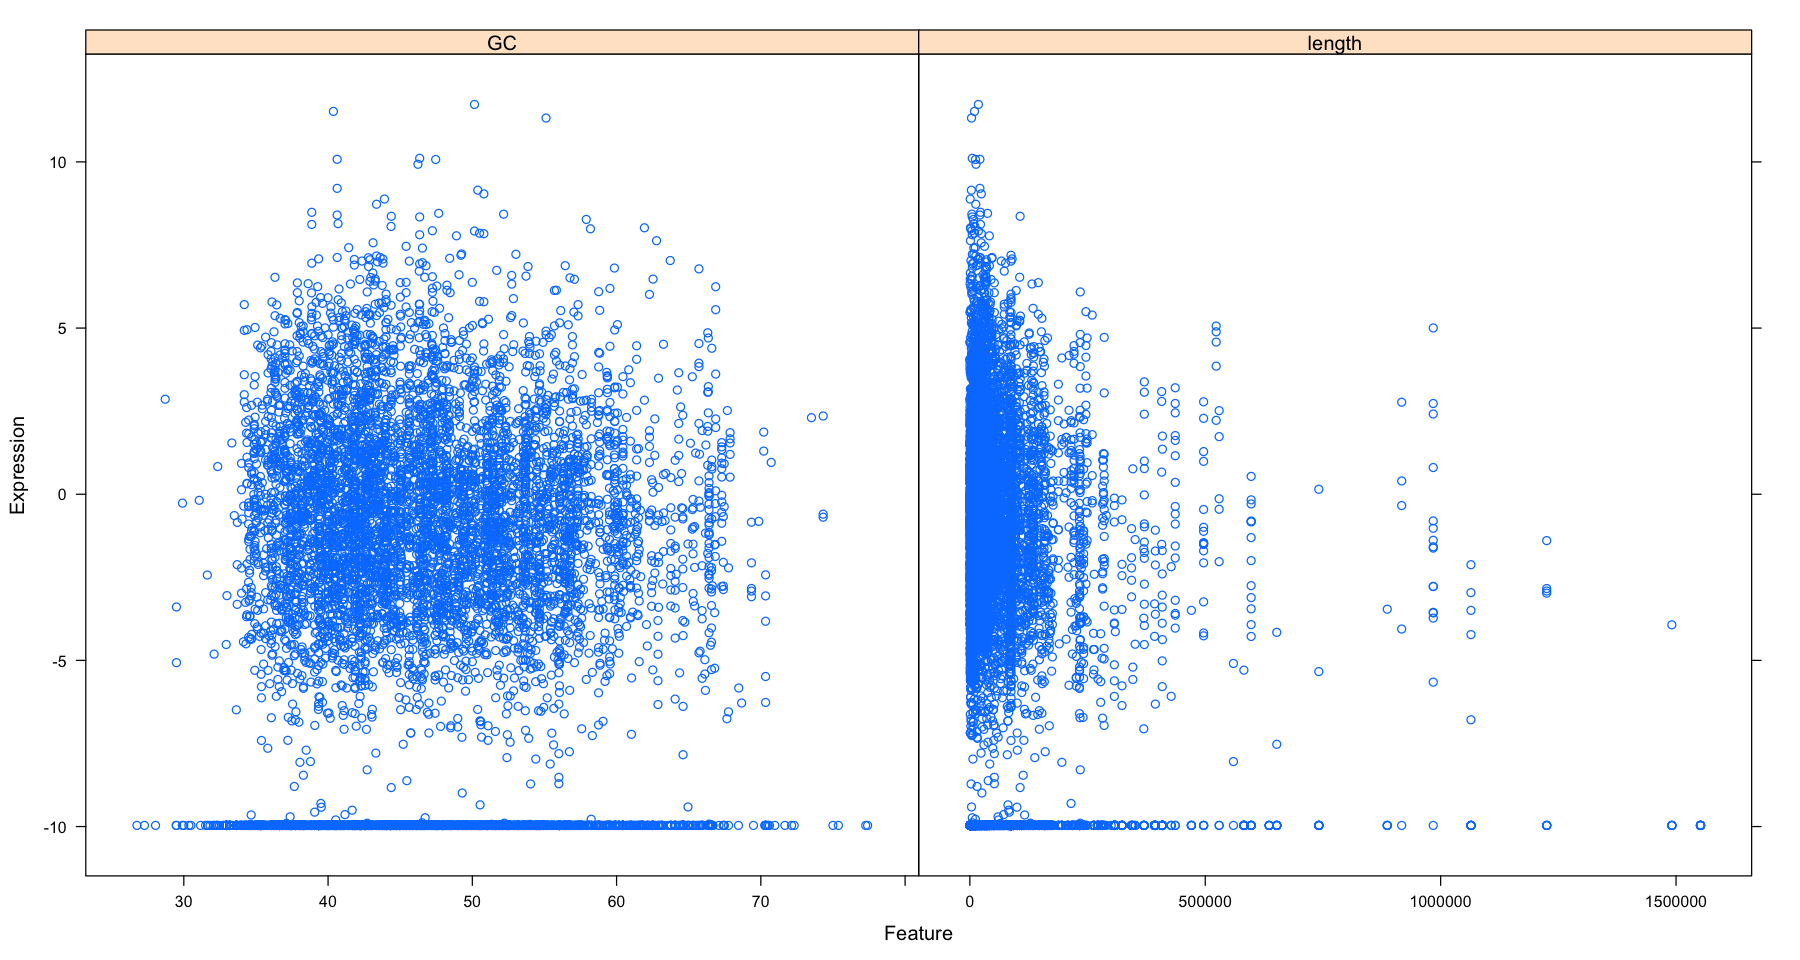

In [21]:
#use one cell line as example
expr_sub <- expr[1:10000, ]
options(repr.plot.width=15, repr.plot.height=8)
featurePlot(x = expr_sub[ , c("GC","length")], y = expr_sub$HCC827, labels = c("Feature", "Expression"))

In [36]:
featureSelection <- function(x, y, method, features.no, shrink=T, x_raw=NULL){
  if(is.null(x_raw)){
    x_raw <- x
  }
  switch(method,
         "mRMR"={
           if(shrink){
             var_features <- apply(x_raw, MARGIN=2, sd, na.rm=T)
             mad_features <- apply(x_raw, MARGIN=2, mad, na.rm=T)
             temp <- which(var_features > quantile(var_features, .75, na.rm=T) & 
                             mad_features > quantile(mad_features, .75, na.rm=T))
             if(length(temp) > features.no){
               x <- x[, temp, drop=FALSE]
             }
           }
           
           f_data <- mRMR.data(data=as.data.frame(cbind(x, y), stringAsFactor=FALSE))
           features <- mRMR.ensemble(data=f_data,
                                     target_indices=ncol(x) + 1,
                                     feature_count=features.no,
                                     solution_count=1)
           features <- features@feature_names[unlist(features@filters)]
         },
         "variance"={
           var_features <- apply(x_raw, MARGIN=2, var, na.rm=T)
           features <- names(sort(var_features, decreasing=T))[1:features.no]
         },
         "mad"={
           var_features <- apply(x_raw, MARGIN=2, mad, na.rm=T)
           features <- names(sort(var_features, decreasing=T))[1:features.no]
         })
  return(features)
}

In [47]:
tt <- featureSelection(x = exprs_sub[,c("GC","length")], y=exprs_sub[,"gene_exprs"],features.no=2, method="mRMR")

In [48]:
str(tt)

 chr [1:2] "GC" "length"


# 1. <u>Elastic Net with K-fold cross validation</u>

In [ ]:
set.seed(123)

### Use small sample of matrix for testing (n=10,000)

In [32]:
exprs_sub <- expr[1:50000,c(500,673, 674)]
colnames(exprs_sub)[1] <- "gene_exprs"
head(exprs_sub)

,gene_exprs,GC,length
,<dbl>,<dbl>,<dbl>
ENST00000456328.2,-0.02193137,57.50,2541
ENST00000450305.2,-9.96578428,57.50,2541
ENST00000488147.1,2.02392740,54.43,15167
ENST00000619216.1,-9.96578428,61.76,68
ENST00000473358.1,-9.96578428,48.84,1556
ENST00000469289.1,-9.96578428,48.84,1556


### Train model

In [33]:
transcript_model <- train(
  gene_exprs ~., #y-values (trying one sample)
  data=exprs_sub, #df with rows as samples and columns as features
  method = "glmnet",
  trControl = trainControl(
    method = "cv", 
    number = 10,
    verboseIter = TRUE
  )
)

+ Fold01: alpha=0.10, lambda=0.1085 
- Fold01: alpha=0.10, lambda=0.1085 
+ Fold01: alpha=0.55, lambda=0.1085 
- Fold01: alpha=0.55, lambda=0.1085 
+ Fold01: alpha=1.00, lambda=0.1085 
- Fold01: alpha=1.00, lambda=0.1085 
+ Fold02: alpha=0.10, lambda=0.1085 
- Fold02: alpha=0.10, lambda=0.1085 
+ Fold02: alpha=0.55, lambda=0.1085 
- Fold02: alpha=0.55, lambda=0.1085 
+ Fold02: alpha=1.00, lambda=0.1085 
- Fold02: alpha=1.00, lambda=0.1085 
+ Fold03: alpha=0.10, lambda=0.1085 
- Fold03: alpha=0.10, lambda=0.1085 
+ Fold03: alpha=0.55, lambda=0.1085 
- Fold03: alpha=0.55, lambda=0.1085 
+ Fold03: alpha=1.00, lambda=0.1085 
- Fold03: alpha=1.00, lambda=0.1085 
+ Fold04: alpha=0.10, lambda=0.1085 
- Fold04: alpha=0.10, lambda=0.1085 
+ Fold04: alpha=0.55, lambda=0.1085 
- Fold04: alpha=0.55, lambda=0.1085 
+ Fold04: alpha=1.00, lambda=0.1085 
- Fold04: alpha=1.00, lambda=0.1085 
+ Fold05: alpha=0.10, lambda=0.1085 
- Fold05: alpha=0.10, lambda=0.1085 
+ Fold05: alpha=0.55, lambda=0.1085 
-

In [35]:
transcript_model

glmnet 

50000 samples
    2 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 45000, 45000, 45000, 45000, 45000, 45000, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared    MAE     
  0.10   0.001085067  5.117198  0.01272463  4.644359
  0.10   0.010850667  5.117198  0.01272463  4.644359
  0.10   0.108506666  5.117240  0.01272411  4.645476
  0.55   0.001085067  5.117198  0.01272443  4.644358
  0.55   0.010850667  5.117203  0.01272407  4.644595
  0.55   0.108506666  5.117782  0.01270068  4.648927
  1.00   0.001085067  5.117198  0.01272456  4.644352
  1.00   0.010850667  5.117216  0.01272320  4.644929
  1.00   0.108506666  5.118959  0.01262759  4.652582

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 0.1 and lambda = 0.01085067.